<a href="https://colab.research.google.com/github/Trongnhat191/Yeast-Cell-Detection/blob/main/unet_model_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Yeast

/content/drive/MyDrive/Yeast


In [ ]:
# !pip install koila
# import koila

/usr/local/lib/python3.10/dist-packages/pynvml/smi.py:5: FutureWarning: The pynvml.smi module is deprecated and will be removed in the next release of pynvml. Please use pynvml_utils:
(e.g. `from pynvml_utils import nvidia_smi`)
  warnings.warn(


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import load_model
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
# import koila

# **Unet**

In [ ]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lr = 1e-4
epochs = 100
height = 1280
width = 1280
batch_size = 3

In [ ]:
dataset_path = os.path.join("dataset","non-aug")
files_dir = os.path.join("files","non-aug")

model_file = os.path.join(files_dir,"1280unet-non-aug.keras")
log_file = os.path.join(files_dir, "1280log-non-aug.csv")

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
create_dir(files_dir)

### *Building Unet*

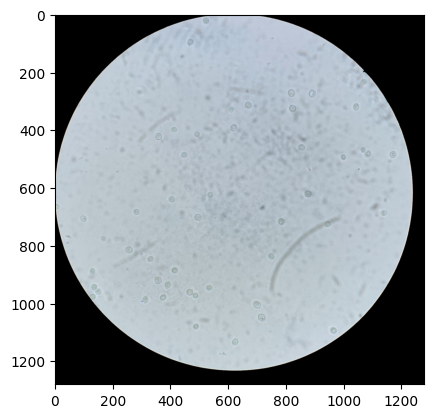

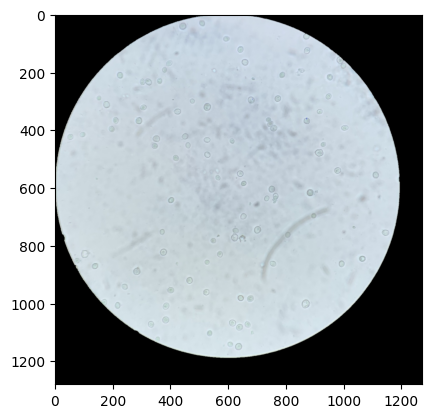

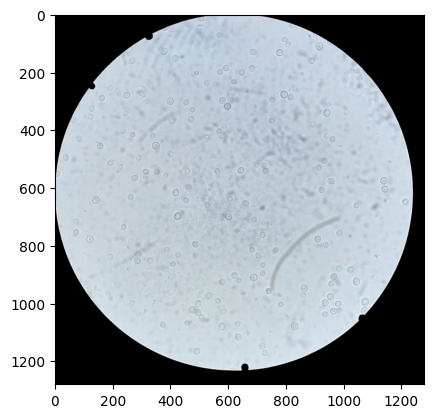

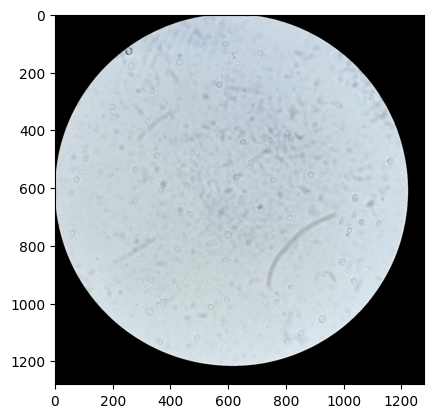

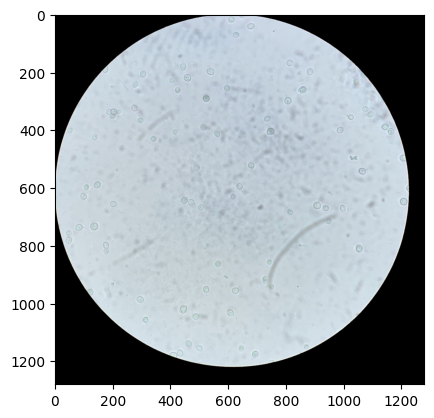

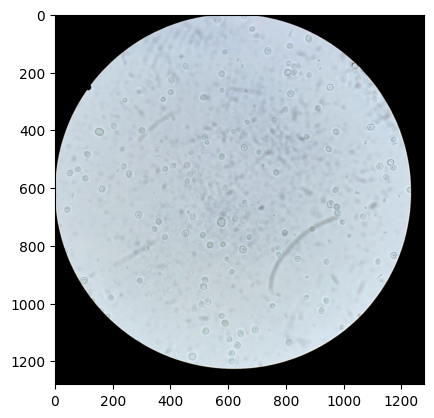

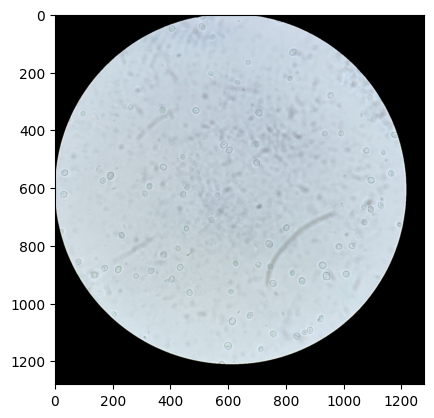

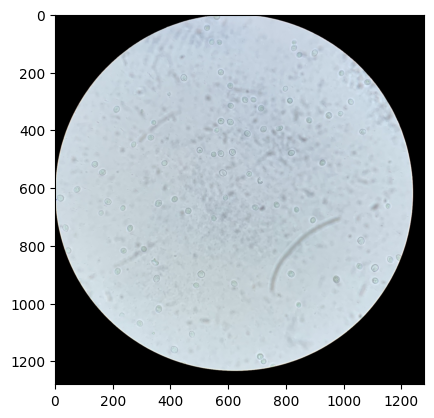

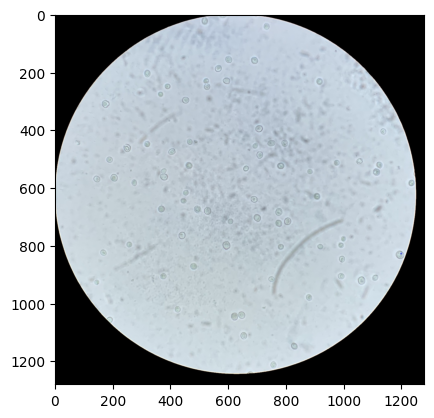

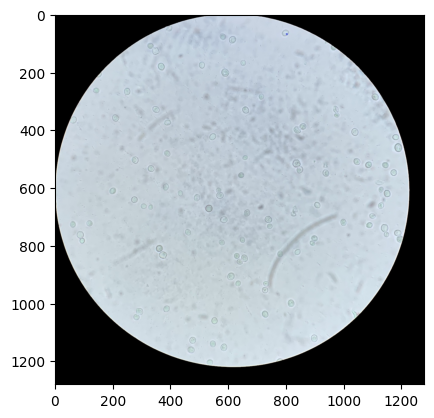

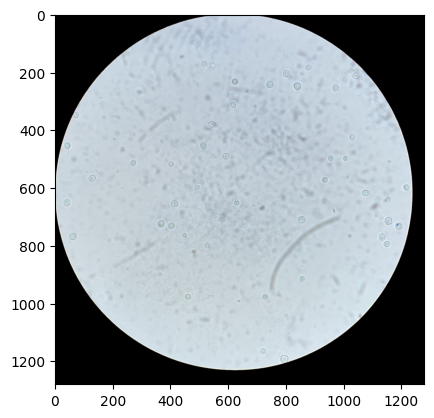

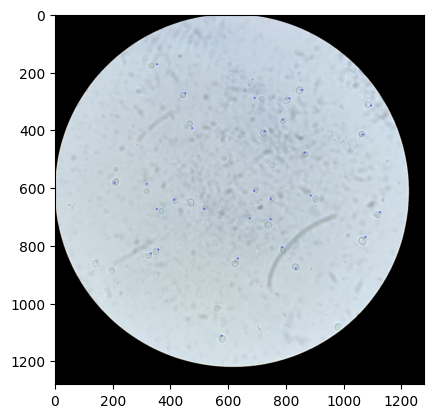

In [ ]:
path = glob(os.path.join("dataset","non-aug","train","images","*"))
for i in path:
  image = cv2.imread(i)
  image = image[:1280,:1280,:]
  plt.imshow(image)
  plt.show()
  cv2.imwrite(i, image)

In [ ]:
def pad_image(img_path_array, target_size):
  for img_path in img_path_array:
    image = cv2.imread(img_path)
    H, W = image.shape[:2]
    target_H, target_W = target_size

    pad_height = max(0, target_H - H)
    pad_width = max(0, target_W - W)

    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    padded_image = padded_image[:target_H, :target_W, :]
    cv2.imwrite(img_path, padded_image)

Conv Block

In [ ]:
def conv_block(inputs, num_filters):
    # x = Conv2D(num_filters,3,padding="same")(inputs)
    # x = BatchNormalization()(x)
    # x = Activation("relu")(x)

    x = Conv2D(num_filters,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

Encoder Block

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D(2, 2)(x)
    return x,p

Decoder Block

In [ ]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    # concat_tensor = tf.image.resize_with_crop_or_pad(concat_tensor, tf.shape(x)[1], tf.shape(x)[2])
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

UNET

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2,256)

    """ Bridge """
    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)
    model = Model(inputs,outputs, name = "UNET")

    return model

Dataset Pipeline

In [ ]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "mask", "*")))

    valid_x = sorted(glob(os.path.join(path, "valid", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "valid", "mask", "*")))

    return (train_x,train_y), (valid_x,valid_y)

Reading Img

In [ ]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    #image = tf.image.resize_with_crop_or_pad(image, [new_height, new_width], method=tf.image.ResizeMethod.BICUBIC)
    image = tf.cast(image, tf.float32) / 255.0
    return image

Readin Mask

In [ ]:
def read_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.resize_with_crop_or_pad(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

tf.data pipeline

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x,y

    x,y = tf.numpy_function(_parse,[x,y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

In [ ]:
def tf_dataset(x, y , batch = 2):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

Training

In [ ]:
(train_x, train_y),(valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 34 - 34
Valid: 5 - 5


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
for x, y in train_dataset:
    print(x.shape, y.shape)

(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(3, 1280, 1280, 3) (3, 1280, 1280, 1)
(1, 1280, 1280, 3) (1, 1280, 1280, 1)


In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [ ]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1280, 1280, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1280, 1280, 64) │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1280, 1280, 64) │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1280, 1280, 64) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 640, 640, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 640, 640, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 640, 640, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 640, 640, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 320, 320, 128)  │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 320, 320, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 320, 320, 256)  │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 320, 320, 256)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 160, 160, 256)  │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 160, 160, 512)  │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 160, 160, 512)  │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 160, 160, 512)  │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 6,965,985 (26.57 MB)

 Trainable params: 6,962,081 (26.56 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [ ]:
opt = tf.keras.optimizers.Adam(lr) # Use tf.keras.optimizers instead of tf.keras.optimizer
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
]

In [ ]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    callbacks = callbacks,
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.5731 - mean_io_u: 0.4731
Epoch 1: val_loss improved from inf to 0.59277, saving model to files/non-aug/1280unet-non-aug.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - loss: 0.5680 - mean_io_u: 0.4718 - val_loss: 0.5928 - val_mean_io_u: 0.4852 - learning_rate: 1.0000e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3562 - mean_io_u: 0.4731
Epoch 2: val_loss improved from 0.59277 to 0.57751, saving model to files/non-aug/1280unet-non-aug.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.3548 - mean_io_u: 0.4718 - val_loss: 0.5775 - val_mean_io_u: 0.4852 - learning_rate: 1.0000e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2778 - mean_io_u: 0.4731
Epoch 3: val_loss improved from 0.57751 to 0.55819, saving model to files/non-aug/1280unet-non-aug.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.2771 - mean_io_u: 0.4718 - val_loss: 0.5582 - val_mean_io_u: 0.4852 - learning_rate: 1.0000e-0

### *Load thử model dự đoán mask của ảnh train*

In [ ]:
unet = load_model("files/non-aug/1280unet-non-aug.keras")

In [ ]:
images_direct = "BackTest/2h"
images_path_list = os.listdir(images_direct)

In [ ]:
images_path_list

['F1-B1-2h-08.jpeg',
 'F1-B1-2h-01.jpeg',
 'F1-B1-2h-04.jpeg',
 'F1-B1-2h-05.jpeg',
 'F1-B1-2h-11.jpeg',
 'F1-B1-2h-12.jpeg',
 'F1-B1-2h-10.jpeg',
 'F1-B1-2h-06.jpeg',
 'F1-B1-2h-09.jpeg',
 'F1-B1-2h-07.jpeg',
 'F1-B1-2h-02.jpeg',
 'F1-B1-2h-03.jpeg']

In [ ]:
def pad_img(img, target_size):
    # Lấy kích thước hiện tại của ảnh
    h, w = img.shape[:2]

    # Tính toán số lượng padding cần thiết
    pad_h = max(0, (target_size[0] - h) // 2)
    pad_w = max(0, (target_size[1] - w) // 2)

    ex1 = (target_size[0] - h) % 2
    ex2 = (target_size[1] - w) % 2
    # Pad ảnh sao cho kích thước đạt target_size
    padded_img = cv2.copyMakeBorder(
        img,
        pad_h, pad_h + ex1, pad_w, pad_w +ex2,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    # Cắt ảnh nếu kích thước vượt quá target_size sau padding
    padded_img = padded_img[:target_size[0], :target_size[1]]

    return padded_img

In [ ]:
images = []

for f in images_path_list:
    image_path = os.path.join(images_direct, f)
    image = read_image(image_path)
    images.append(image)

images = np.array(images)

In [ ]:
images.shape

(12, 1280, 1280, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


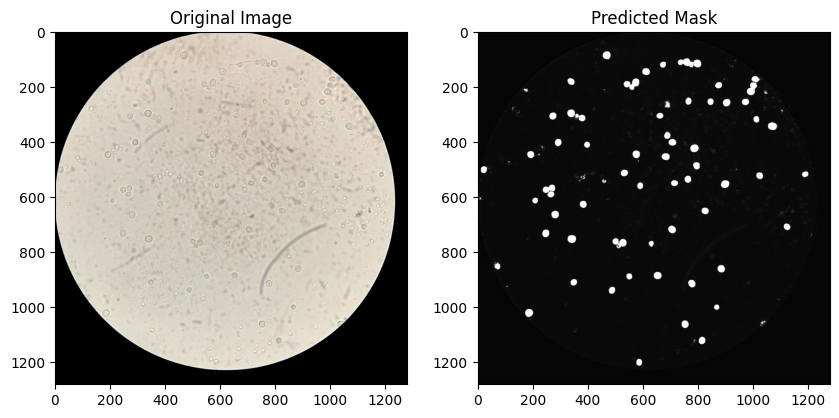

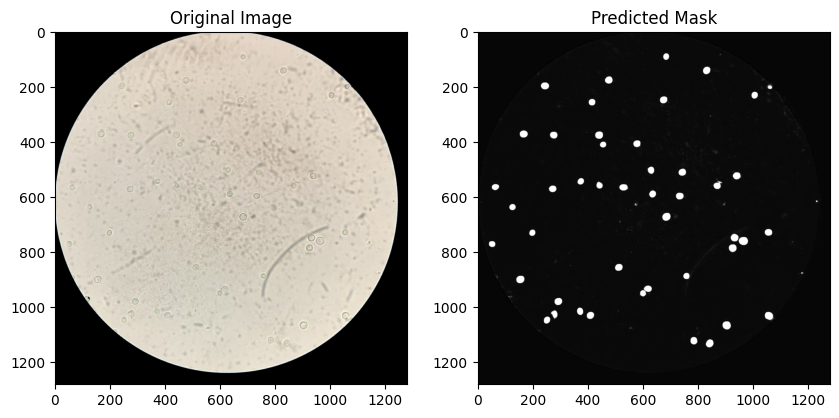

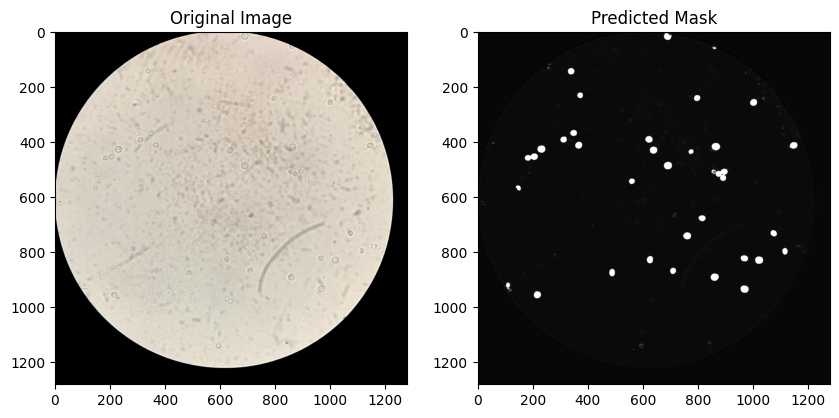

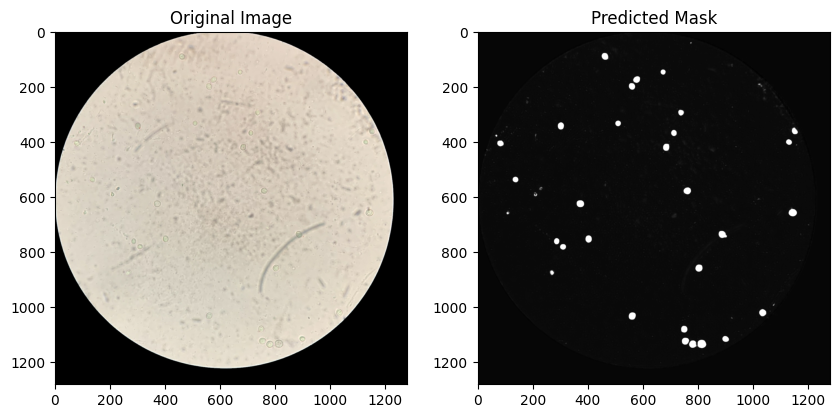

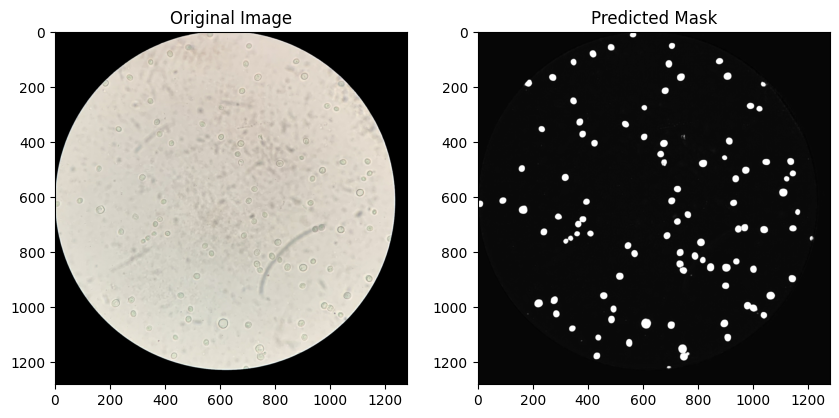

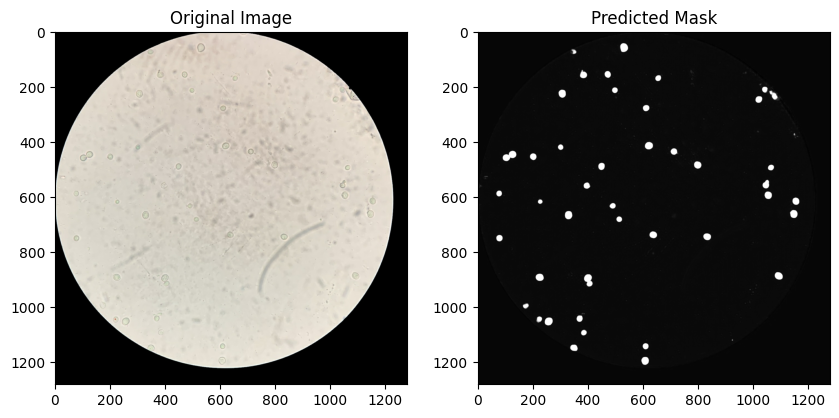

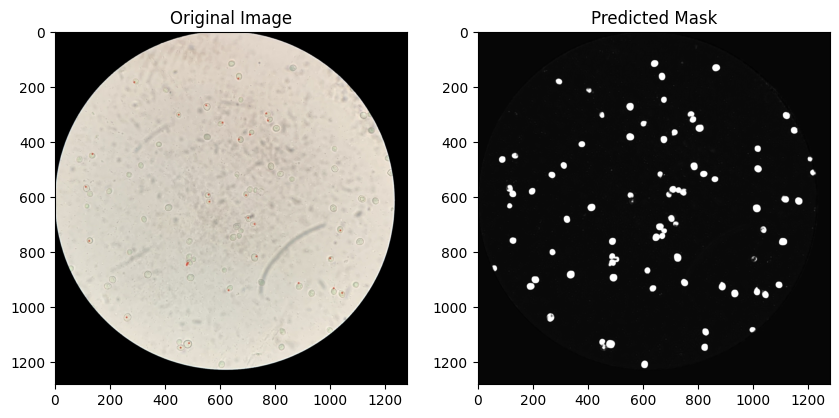

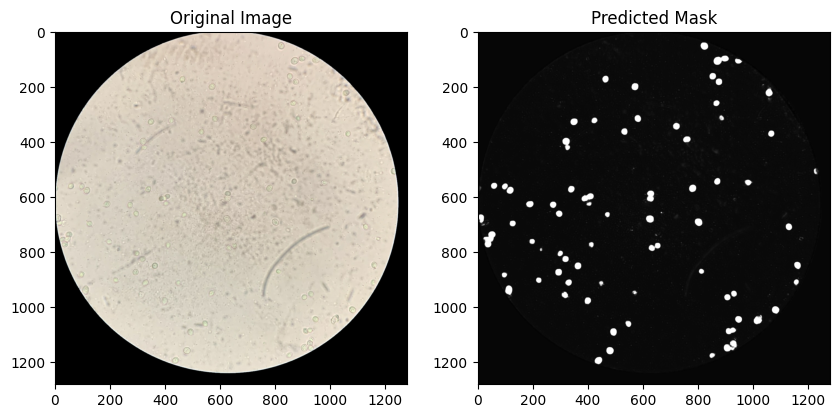

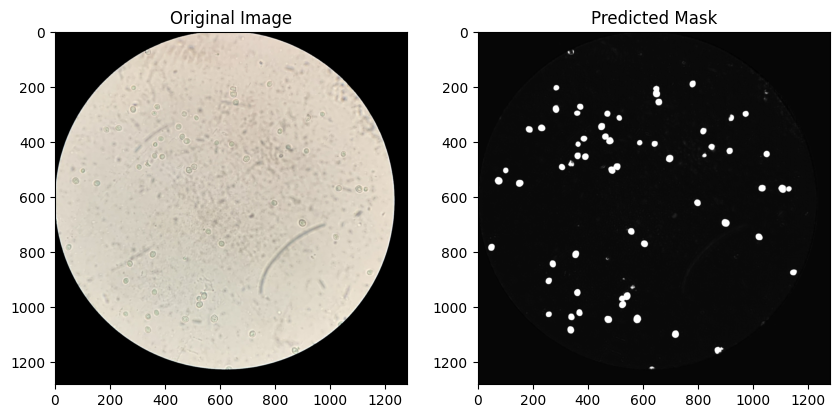

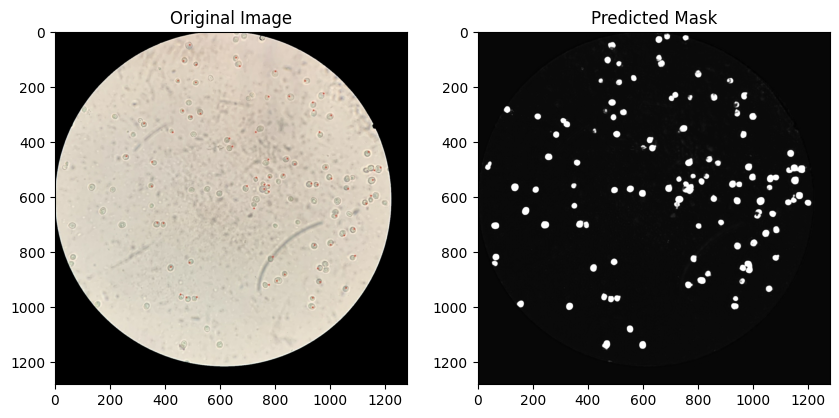

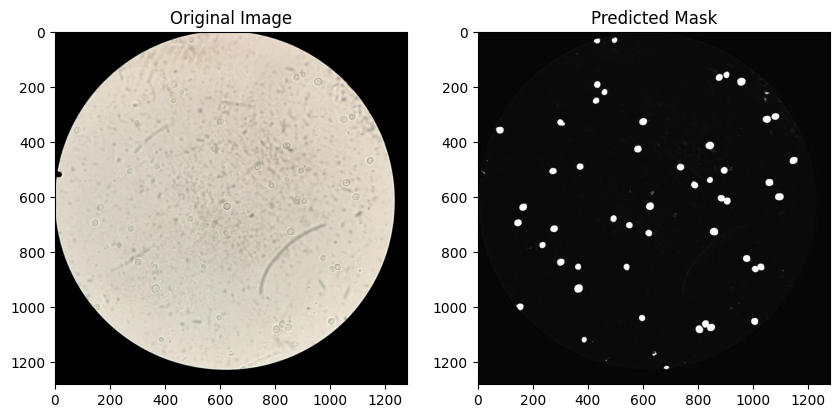

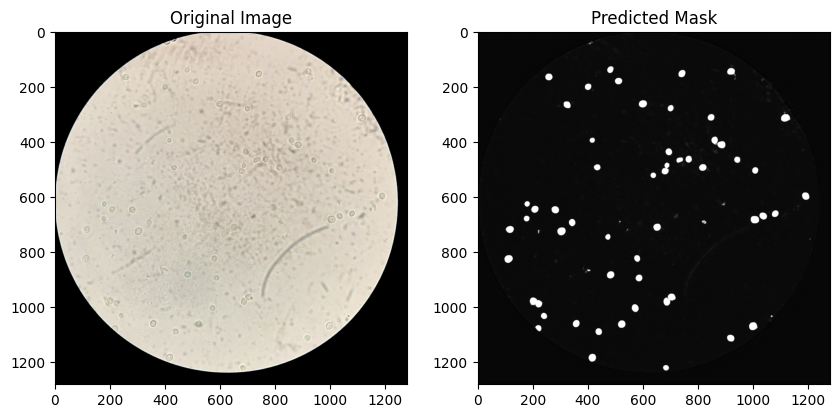

In [ ]:
output_dir = "BackTest/Untitled folder"
os.makedirs(output_dir, exist_ok=True)
batch_size = 1
predictions = []
for i in range(0, len(images), batch_size):
    batch_predictions = unet.predict(images[i:i+batch_size])
    predictions.extend(batch_predictions)

predictions = np.array(predictions)

# Hiển thị và lưu các ảnh và mask dự đoán tương ứng
for i in range(len(images_path_list)):
    plt.figure(figsize=(10, 5))

    # Ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title("Original Image")

    # Mask dự đoán
    plt.subplot(1, 2, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    output_file = os.path.join(output_dir, images_path_list[i])
    predictions[i] = predictions[i].astype(np.uint8)
    plt.imsave(output_file, predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

In [ ]:
images_direct = "BackTest/2h"
images_path_list = os.listdir(images_direct)
mask_direct = "BackTest/mask2h"
mask_path_list = os.listdir(mask_direct)
print(images_path_list)
print("-" * 100)
print(mask_path_list)

['F1-B1-2h-08.jpeg', 'F1-B1-2h-01.jpeg', 'F1-B1-2h-04.jpeg', 'F1-B1-2h-05.jpeg', 'F1-B1-2h-11.jpeg', 'F1-B1-2h-12.jpeg', 'F1-B1-2h-10.jpeg', 'F1-B1-2h-06.jpeg', 'F1-B1-2h-09.jpeg', 'F1-B1-2h-07.jpeg', 'F1-B1-2h-02.jpeg', 'F1-B1-2h-03.jpeg']
----------------------------------------------------------------------------------------------------
['F1-B1-2h-10.jpeg', 'F1-B1-2h-12.jpeg', 'F1-B1-2h-03.jpeg', 'F1-B1-2h-02.jpeg', 'F1-B1-2h-05.jpeg', 'F1-B1-2h-01.jpeg', 'F1-B1-2h-08.jpeg', 'F1-B1-2h-11.jpeg', 'F1-B1-2h-04.jpeg', 'F1-B1-2h-07.jpeg', 'F1-B1-2h-09.jpeg', 'F1-B1-2h-06.jpeg']


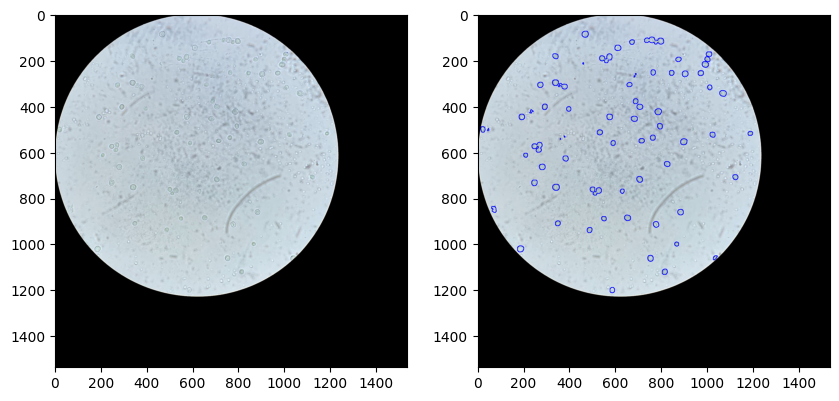

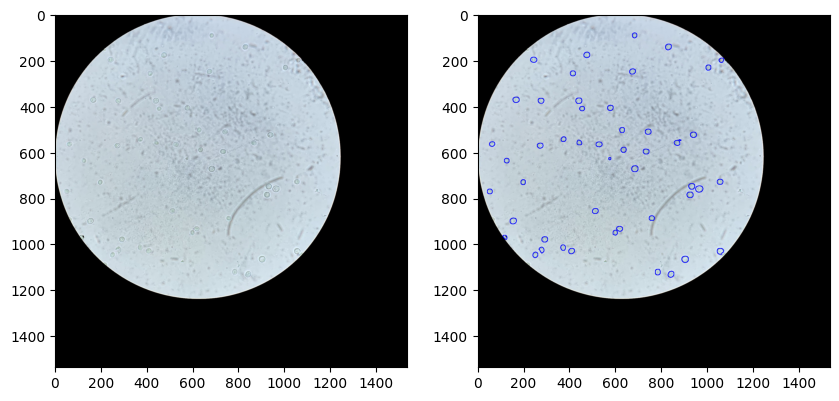

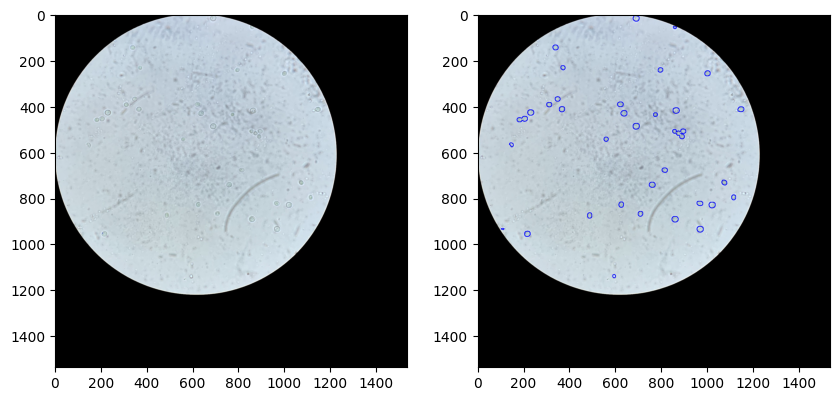

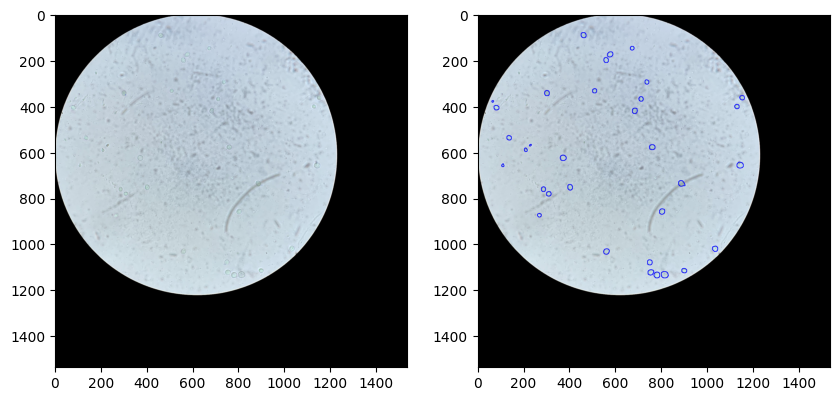

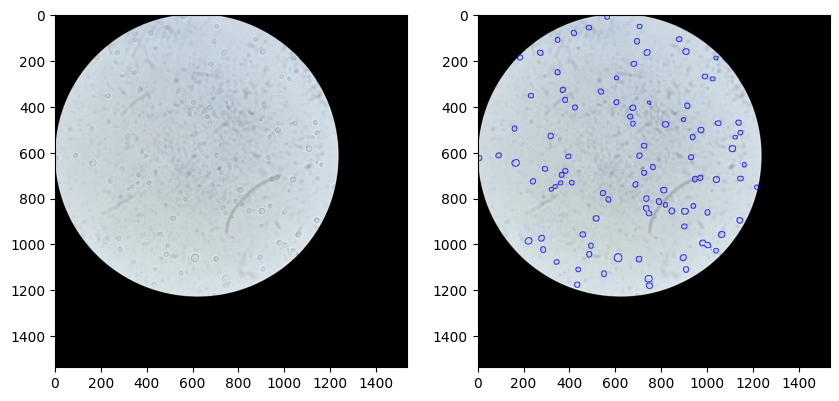

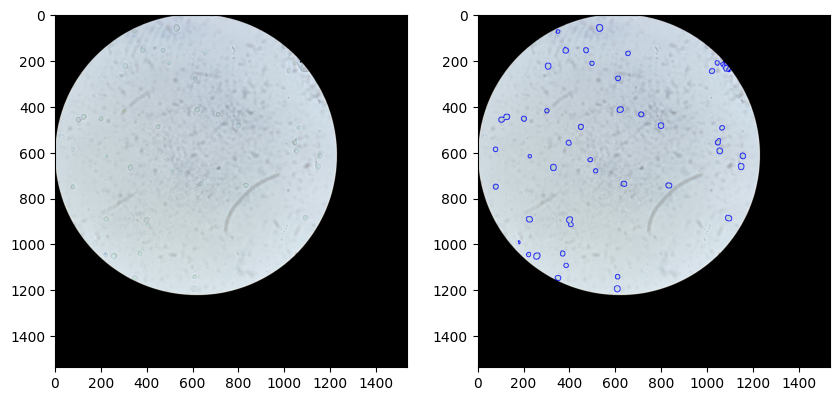

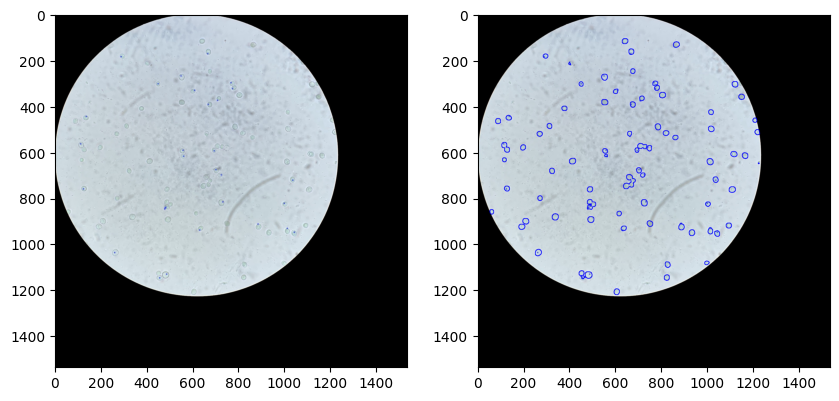

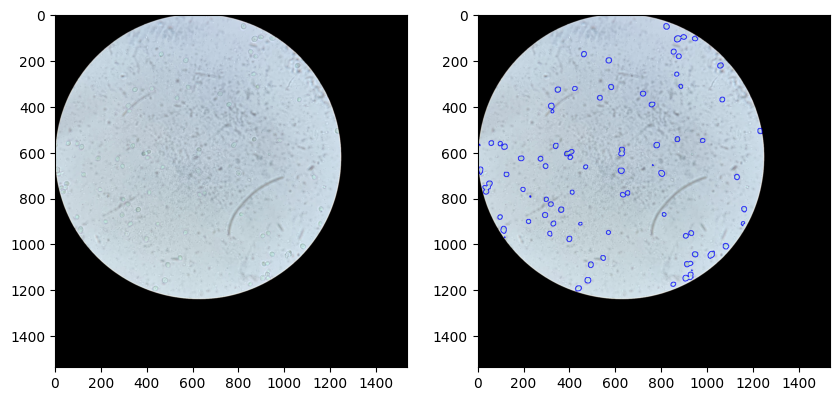

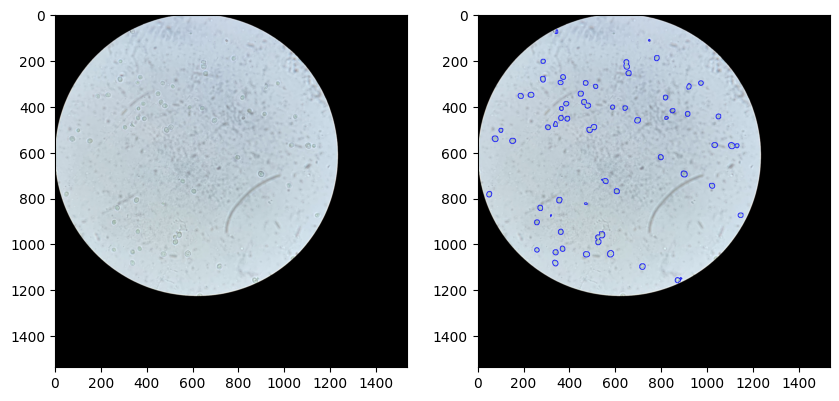

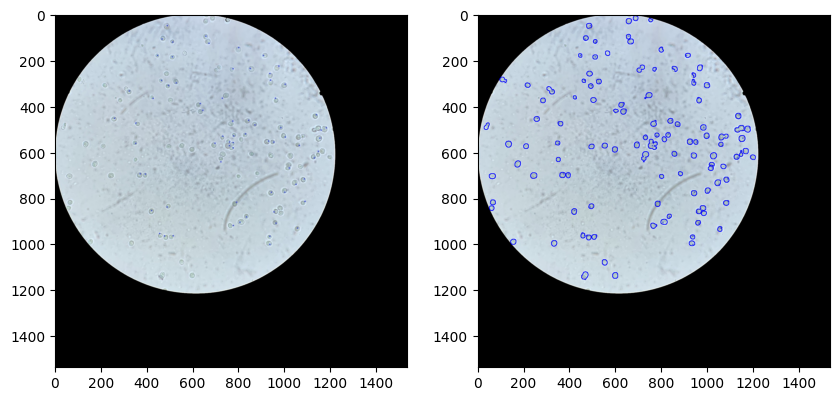

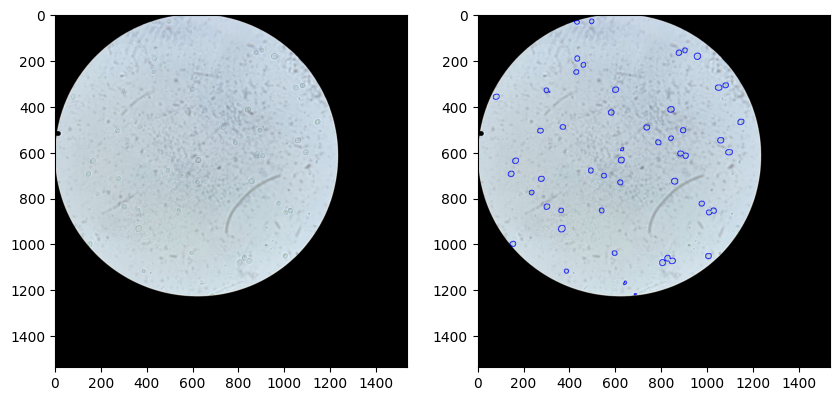

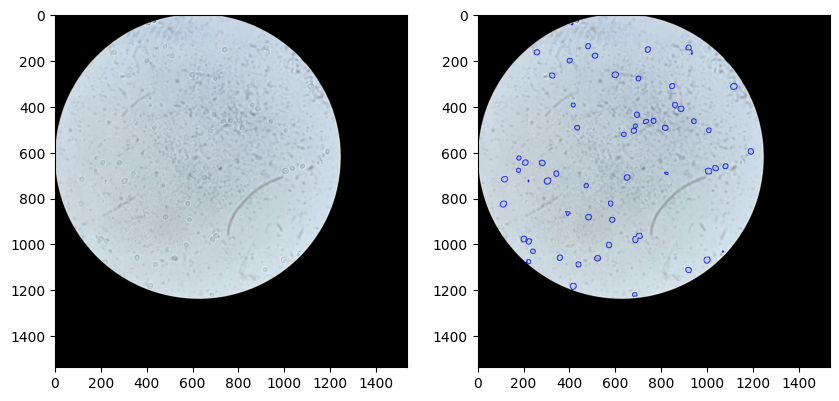

In [ ]:
MIN_WIDTH = 4
MAX_HEIGHT = height / 2
for ip in images_path_list:
  image = cv2.imread(os.path.join(images_direct,ip))
  mask = cv2.imread(os.path.join(mask_direct,ip), cv2.IMREAD_GRAYSCALE)
  # plt.figure(figsize=(10, 5))
  # plt.imshow(image)
  # plt.show()
  # plt.figure(figsize=(10, 5))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  # plt.imshow(mask, cmap='gray')
  # plt.show()

  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w >= MIN_WIDTH and h < MAX_HEIGHT and h > MIN_WIDTH:
      cv2.drawContours(image, [cnt], -1, (0, 0, 255), 2)

  plt.subplot(1, 2, 2)
  plt.imshow(image)
  #cv2.imwrite(os.path.join("train_data/drawcontour", ip), image)
  plt.show()




(35, 1536, 1536, 3)


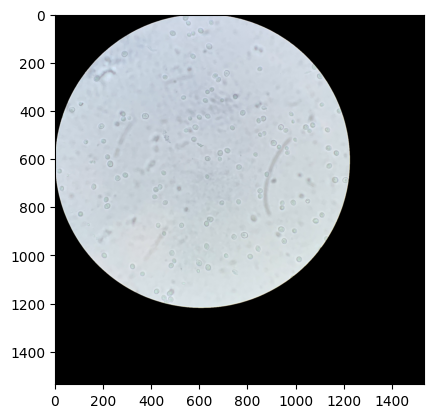

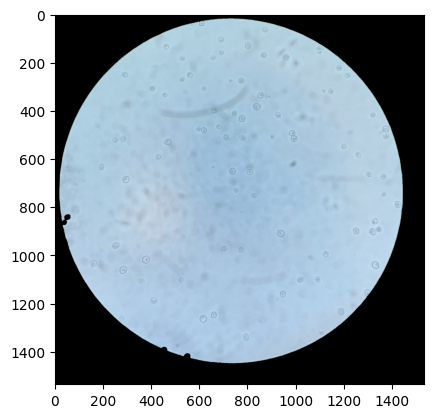

In [ ]:
images_train_direct = "dataset/non-aug/train/images"
mask_train_direct = "dataset/non-aug/train/mask"
images_data_direct = "train_data/images"
images_train = []
images_data = []
images_path_train = os.listdir(images_train_direct)
images_path_data = os.listdir(images_data_direct)
for ip in images_path_train:
  image = cv2.imread(os.path.join(images_train_direct,ip))
  images_train.append(image)
images_train = np.array(images_train)
print(images_train.shape)
for ip in images_path_data:
  image = cv2.imread(os.path.join(images_data_direct,ip))
  images_data.append(image)
images_data = np.array(images_data)
plt.imshow(images_train[0])
plt.show()
plt.imshow(images_data[0])
plt.show()
